# Kraggle competition - houses prices

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config; set_config(display='diagram')

from xgboost import XGBRegressor

In [3]:
data = pd.read_csv("data/houses_kraggle.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
X = data.drop(columns='SalePrice')
y = data['SalePrice']

## Baseline Preprocessing

### Reduce complexity of model

In [18]:
num_col = X.select_dtypes(exclude = 'object').columns
num_col.size

37

In [19]:
print(X.select_dtypes(include = 'object').columns.size)
feat_categorical_nunique = X.select_dtypes('object').nunique().sum()
feat_categorical_nunique

43


252

In [20]:
w = X.select_dtypes('object').nunique()
feat_categorical_small = list(w[(w <7)].index)
len(feat_categorical_small)

34

### Impute, scale and encode

In [21]:
cat_transform = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
num_transform = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())

preproc_baseline = make_column_transformer((cat_transform, feat_categorical_small), (num_transform, num_col))
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQua...
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object'))])

In [22]:
X_scaled = preproc_baseline.fit_transform(X)

## Baseline Models

In [23]:
pipe_baseline = make_pipeline(preproc_baseline, Ridge())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQu...
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object'))])),
                ('ridge', Ridge())])

In [26]:
def root_mean_squared_log_error(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)
    log_error = np.log(1+t) - np.log(1+p)
    return ((log_error**2).mean())**0.5

# This is our metric to minimize
rmsle = make_scorer(root_mean_squared_log_error)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * root_mean_squared_log_error(y_true, y_pred))

In [27]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring = rmsle_neg).mean()
score_baseline

-0.16631913339626264

## Real preprocessing

### Ordinal Encoding

In [28]:
X = X.where(pd.notnull(X), None)

In [29]:
X = X.drop(columns='Id')
num_col = list(X.select_dtypes(exclude='object').columns)

In [30]:
lot_shape = ['Reg', 'IR1', 'IR2','IR3']
land_contour = ['Lvl', 'Bnk', 'HLS','Low']
utilities = ['AllPub', 'NoSewr', 'NoSeWa','ELO']
land_slope = ['Gtl', 'Mod', 'Sev']
exter_qual = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
exter_cond = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
bsmt_qual = ['Ex', 'Gd', 'TA', 'Fa', 'Po', None]
bsmt_cond = ['Ex', 'Gd', 'TA', 'Fa', 'Po', None]
bsmt_exposure = ['Gd', 'Av', 'Mn', 'No', None]
bsmt_fin_type1 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', None]
bsmt_fin_type2 =  ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', None]
heating_qc = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
kitchen_qual = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
fireplace_qu = ['Ex', 'Gd', 'TA', 'Fa', 'Po', None]
garage_finish = ['Fin', 'RFn', 'Unf', None]
garage_qual = ['Ex', 'Gd', 'TA', 'Fa', 'Po', None]
garage_cond = ['Ex', 'Gd', 'TA', 'Fa', 'Po', None]
paved_drive = ['Y', 'P', 'N']
pool_qc = ['Ex', 'Gd', 'TA', 'Fa', None]
fence = ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', None]

categories = [lot_shape, land_contour, utilities, land_slope, exter_qual, exter_cond,
              bsmt_qual, bsmt_cond, bsmt_exposure, bsmt_fin_type1, bsmt_fin_type2,
              heating_qc, kitchen_qual, fireplace_qu, garage_finish, garage_qual,
              garage_cond, paved_drive, pool_qc, fence]

columns = ['LotShape', 'LandContour', 'Utilities',
       'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

encoder = OrdinalEncoder(
    categories=categories,
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

encoder.fit(X[columns])

encoder.transform(X[columns])

array([[0., 0., 0., ..., 0., 4., 4.],
       [0., 0., 0., ..., 0., 4., 4.],
       [1., 0., 0., ..., 0., 4., 4.],
       ...,
       [0., 0., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 4., 4.],
       [0., 0., 0., ..., 0., 4., 4.]])

### Pipeline with all encoders

In [49]:
preproc_nominal = X[feat_categorical_small].drop(columns=columns).columns
preproc_ordinal = columns


oho_transform = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
label_transform = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=categories))
num_transform = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())

preproc = make_column_transformer((num_transform, num_col),
                                           (label_transform, preproc_ordinal),
                                           (oho_transform, preproc_nominal),
                                 remainder="drop")


preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['MSSubClass', 'LotArea', 'OverallQual',
                                  'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                  'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
                                  'BsmtHalfBath', 'FullBath'...
                                  'PoolQC', 'Fence']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['MSZoning', 'Street', 'Alley', 'LotConfig', 'BldgType', 'RoofStyle',
       'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical',
       'GarageType', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])

### Target engineering

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

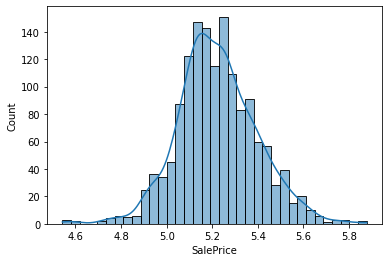

In [50]:
y_log = np.log10(y)
sns.histplot(x=y_log, kde=True)

In [51]:
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

### Feature Selection

In [52]:
preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50,
)

preproc = make_pipeline(
    preproc,
    preproc_selector,
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['MSSubClass', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'Bs...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['MSZoning', 'Street', 'Alley', 'LotConfig', 'BldgType', 'RoofStyle',
       'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical',
       'GarageType', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7f21f3d1a550>))])

In [55]:
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)
preproc_fitted_log.transform(X).shape

(1460, 61)

In [56]:
preproc.fit_transform(X, y_log)

array([[0.23529412, 0.0334198 , 0.66666667, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.03879502, 0.55555556, ..., 0.        , 1.        ,
        0.        ],
       [0.23529412, 0.04650728, 0.66666667, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.29411765, 0.03618687, 0.66666667, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.03934189, 0.44444444, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.04037019, 0.44444444, ..., 0.        , 1.        ,
        0.        ]])

## Real Models

### Linear Models

In [59]:
model = Ridge()
pipe_ridge = make_pipeline(preproc, model)
cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmsle).mean()

0.010185562260257052

### KNN

In [64]:
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)
cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse).mean()

0.09505132122663654

### SVM

In [68]:
model = SVR(kernel='linear')
pipe_svm = make_pipeline(preproc, model)
cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()

0.0682105144894423

In [69]:
model = SVR(kernel='rbf', C = 10)
pipe_svm_rbf = make_pipeline(preproc, model)
cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()

0.07564795052269059

### Random Forest

In [72]:
model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)
pipe = make_pipeline(preproc, model)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.0031762553048766094


0.07065696777235934

### XGBoost

In [76]:
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X,y_log,random_state=42)

In [77]:
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)

In [ ]:
pipe_xgb = make_pipeline(preproc, model_xgb)
cross_val_score(pipe_xgb,X,y_log,cv=5,scoring=rmse,n_jobs=-1).mean()